<a href="https://colab.research.google.com/github/Manvi1718/SandStone-segmentation/blob/main/Sandstone_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [27]:
import os
import numpy as np
import torch
import tifffile as tiff
import matplotlib.pyplot as plt
from skimage import io
from patchify import patchify, unpatchify
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define dataset path
DATASET_PATH = "/content/drive/MyDrive/Sandstone/data_for_3D_Unet"

In [6]:
# Load 3D Image and Mask
image = tiff.imread(os.path.join(DATASET_PATH, "train_images_256_256_256.tif"))
mask = tiff.imread(os.path.join(DATASET_PATH, "train_masks_256_256_256.tif"))


In [7]:
# Patchify images into (64,64,64) subvolumes
patch_size = 64
image_patches = patchify(image, (patch_size, patch_size, patch_size), step=patch_size)
mask_patches = patchify(mask, (patch_size, patch_size, patch_size), step=patch_size)

# Reshape to flatten patches
X = image_patches.reshape(-1, patch_size, patch_size, patch_size)
Y = mask_patches.reshape(-1, patch_size, patch_size, patch_size)

print("Input shape:", X.shape)  # (num_patches, 64, 64, 64)
print("Mask shape:", Y.shape)   # (num_patches, 64, 64, 64)

Input shape: (64, 64, 64, 64)
Mask shape: (64, 64, 64, 64)


In [8]:
# Define dataset class
class SandstoneDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Normalize the image
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dim
        mask = torch.tensor(mask, dtype=torch.long)  # No channel dim for mask

        return image, mask


In [9]:
# Create dataset and DataLoader
dataset = SandstoneDataset(X, Y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [10]:
# Define 3D U-Net Model
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):  # 4 classes in segmentation
        super(UNet3D, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True)
            )

        self.encoder = nn.Sequential(
            conv_block(in_channels, 64),
            nn.MaxPool3d(2),
            conv_block(64, 128),
            nn.MaxPool3d(2)
        )

        self.decoder = nn.Sequential(
            conv_block(128, 64),
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            conv_block(64, out_channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D().to(device)

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
num_epochs = 100
for epoch in range(num_epochs):
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Resize the mask to match the output shape (downsampling)
        masks = masks.float().unsqueeze(1)  # Add channel dim for interpolation
        masks = F.interpolate(masks, size=outputs.shape[2:], mode="nearest")  # Resize mask
        masks = masks.squeeze(1).long()  # Remove extra channel & convert back to long

        # Compute loss
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch % 5 == 0):
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [0/100], Loss: 1.1772
Epoch [5/100], Loss: 0.9786
Epoch [10/100], Loss: 0.9563
Epoch [15/100], Loss: 0.9406
Epoch [20/100], Loss: 0.8025
Epoch [25/100], Loss: 0.7465
Epoch [30/100], Loss: 0.7361
Epoch [35/100], Loss: 0.6810
Epoch [40/100], Loss: 0.6666
Epoch [45/100], Loss: 0.6053
Epoch [50/100], Loss: 0.5647
Epoch [55/100], Loss: 0.5413
Epoch [60/100], Loss: 0.5291
Epoch [65/100], Loss: 0.4867
Epoch [70/100], Loss: 0.4501
Epoch [75/100], Loss: 0.4662
Epoch [80/100], Loss: 0.4459
Epoch [85/100], Loss: 0.4240
Epoch [90/100], Loss: 0.4011
Epoch [95/100], Loss: 0.4192


In [14]:
# Save model
torch.save(model.state_dict(), "/content/drive/MyDrive/Sandstone/3D_Unet_Sandstone_Model.pth")

In [15]:
# Model evaluation
model.eval()
test_image, test_mask = dataset[0]
test_image = test_image.unsqueeze(0).to(device)  # Add batch dim

with torch.no_grad():
    pred_mask = model(test_image)

pred_mask = torch.argmax(pred_mask, dim=1).cpu().numpy()[0]

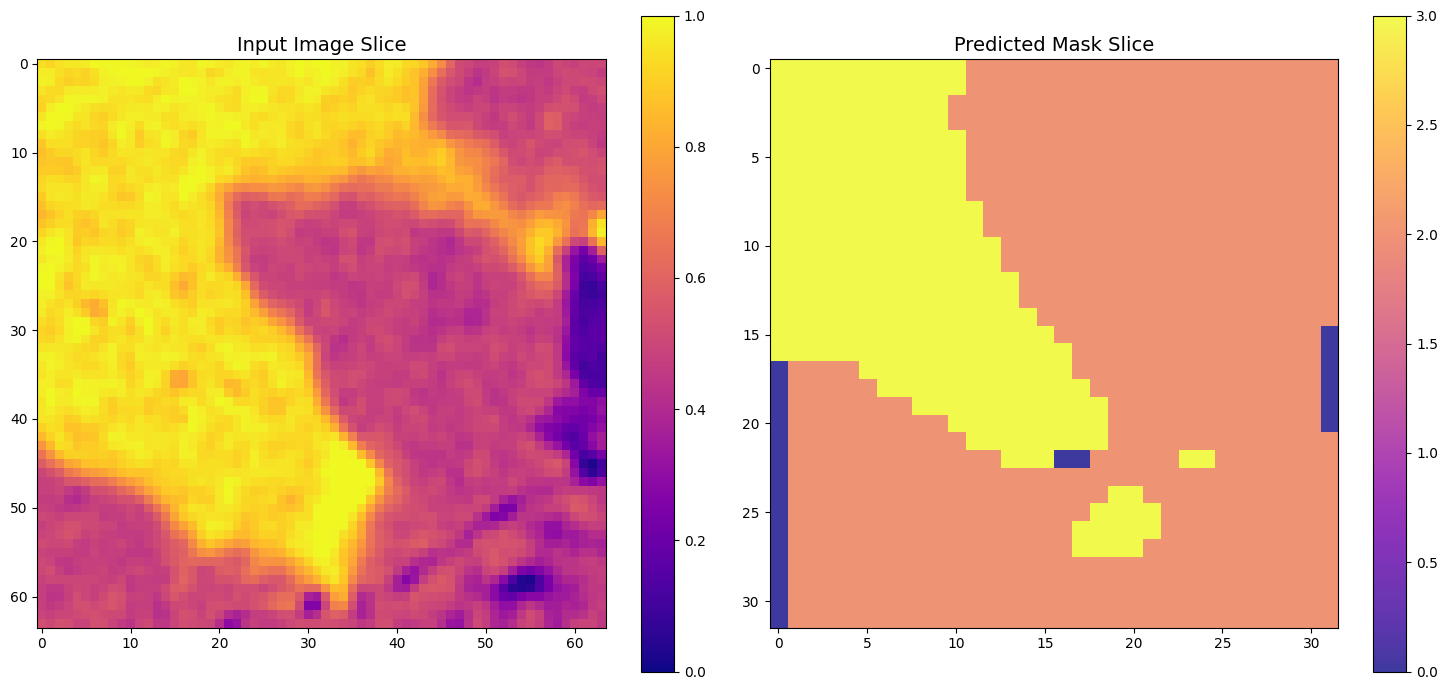

In [16]:
plt.figure(figsize=(15, 7), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Input Image Slice", fontsize=14)
plt.imshow(test_image.cpu().numpy()[0, 0, :, :, 20], cmap='plasma', vmin=0, vmax=1)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Predicted Mask Slice", fontsize=14)
plt.imshow(pred_mask[:, :, 20], cmap='plasma', alpha=0.8)
plt.colorbar()

plt.tight_layout()
plt.show()


In [18]:
# Load large test image
large_image = tiff.imread("/content/drive/MyDrive/Sandstone/data_for_3D_Unet/448_images_512x512.tif")

In [19]:
# Patchify into (64,64,64)
patches = patchify(large_image, (64, 64, 64), step=64)

In [28]:
import torch.nn.functional as F

# Ensure predicted patches have the correct shape
predicted_patches = np.zeros_like(patches)

for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        for k in range(patches.shape[2]):
            single_patch = patches[i, j, k, :, :, :]

            # Convert to tensor
            input_tensor = torch.tensor(single_patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            # Predict
            with torch.no_grad():
                pred_patch = model(input_tensor)

            # Ensure prediction has 3D shape (N, C, D, H, W)
            if pred_patch.ndim == 4:  # (N, C, H, W) -> Convert to (N, C, 1, H, W)
                pred_patch = pred_patch.unsqueeze(2)

            # Get class-wise prediction
            pred_patch = torch.argmax(pred_patch, dim=1, keepdim=True)  # Keep (N, 1, D, H, W)

            # Resize correctly
            pred_patch = F.interpolate(pred_patch.float(), size=(64, 64, 64), mode='trilinear', align_corners=False)

            # Convert back to NumPy
            pred_patch = pred_patch.squeeze(0).squeeze(0).cpu().numpy()

            # Store in correct location
            predicted_patches[i, j, k, :, :, :] = pred_patch

# Reconstruct full image
segmented_image = unpatchify(predicted_patches, large_image.shape)


In [29]:
tiff.imwrite("/content/drive/MyDrive/Sandstone/segmented.tif", segmented_image)